<a href="https://colab.research.google.com/github/OscarG-DataSci/ADS508/blob/colab/ADS508_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import boto3.session
import sagemaker
import os

In [ ]:
!aws s3 ls s3://ads508teamproject

2022-03-17 07:47:05     825534 cyouth_demo_age_20210328.csv
2022-03-17 07:47:08    1118781 cyouth_demo_race_20210328.csv
2022-03-17 07:47:06     310455 cyouth_demo_sex_20210328.csv
2022-03-18 06:47:44   25070533 cyouth_util_age_20210328.csv


In [ ]:
sess = boto3.Session(region_name='us-east-1')

In [ ]:
client = boto3.client('s3')

In [ ]:
resp = client.list_buckets()
resp

{'Buckets': [{'CreationDate': datetime.datetime(2022, 3, 12, 9, 53, 53, tzinfo=tzlocal()),
   'Name': 'ads508teamproject'}],
 'Owner': {'DisplayName': 'tlloyd',
  'ID': '48f14138b8ccbbc0993dd4b3360b951bc781c4f97d5ca71230c87d4a1d8c4443'},
 'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Mon, 21 Mar 2022 06:59:48 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-id-2': 'QFnqhiDr7iGOpUveJkp6+qpuegmJyvEB1qATRIGjqxd6xMfVrJpjnLV46ACWWfVvUrgXHGF8Ha4=',
   'x-amz-request-id': 'F0QH8ADPD09PCTKE'},
  'HTTPStatusCode': 200,
  'HostId': 'QFnqhiDr7iGOpUveJkp6+qpuegmJyvEB1qATRIGjqxd6xMfVrJpjnLV46ACWWfVvUrgXHGF8Ha4=',
  'RequestId': 'F0QH8ADPD09PCTKE',
  'RetryAttempts': 0}}

In [ ]:
s3 = boto3.resource('s3')

In [ ]:
list(s3.buckets.all())

[s3.Bucket(name='ads508teamproject')]

In [ ]:
bucket = s3.Bucket('ads508teamproject')

In [ ]:
files = list(bucket.objects.all())

In [ ]:
for file in files:
    client.download_file('ads508teamproject', file.key, file.key)

In [ ]:
age = pd.read_csv(files[0].key)
demo = pd.read_csv(files[1].key)
sex = pd.read_csv(files[2].key)
util = pd.read_csv(files[3].key)

util.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,AGE_GRP,SVC_DESC,UNIT_TYPE,AMOUNT,AMOUNT_ANNOT,MHS_TYPE
0,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,BENE_COUNT,NaN,1.0,MHS
1,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,TOTAL_MINUTES,NaN,2.0,MHS
2,Alameda,01,2017,A1 Children 0-2,ADAPT_BHV_TX-QHP,BENE_COUNT,19.0,NaN,MHS
3,Alameda,01,2017,A1 Children 0-2,ADAPT_BHV_TX-QHP,TOTAL_MINUTES,56370.0,NaN,MHS
4,Alameda,01,2017,A1 Children 0-2,ADAPT_BHV_TX-TECH,BENE_COUNT,19.0,NaN,MHS


In [ ]:
#Code used before implementation of S3 Bucket via AWS Services

"""
url1 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/9b4b7b99-96de-4cca-b8ad-992f38f60697/download/cyouth_util_age_20210328.csv"
url2 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/1b8821d7-cd56-4fcf-8b15-3cf5d66bdba7/download/cyouth_demo_race_20210328.csv"
url3 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/80447662-f12e-44f7-a31c-5768e6917f2e/download/cyouth_dx_age_20210328.csv"

util = pd.read_csv(url1)
demo = pd.read_csv(url2)
age  = pd.read_csv(url3)
"""

In [ ]:
# SQLite3 database
cnn = sqlite3.connect('sqlite3.db')

In [ ]:
# Load data sets into SQLite3 database
age.to_sql("age", cnn, if_exists='replace')
demo.to_sql("demo", cnn, if_exists='replace')
sex.to_sql("sex", cnn, if_exists='replace')
util.to_sql("util", cnn, if_exists='replace')

In [ ]:
# Load SQL abilities
%load_ext sql
%sql sqlite:///sqlite3.db

In [ ]:
%%sql

with recursive
a( FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, GROUP_NAME, GROUP_TOTAL)
as(
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, RACE_GRP AS GROUP_NAME, SUM(CAST(TOTAL_CT AS BIGINT)) AS GROUP_TOTAL
from  demo
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, RACE_GRP

union

select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SEX, SUM(CAST(TOTAL_CT AS BIGINT)) AS SEX_TOTAL_CT
from sex
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SEX

union

select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, AGE_GRP, SUM(CAST(TOTAL_CT AS BIGINT)) AS AGE_GRP_TOTAL_CT
from age
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, AGE_GRP
)
, b (FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, GROUP_GRAND_TOTAL)
as (
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SUM(GROUP_TOTAL) AS GROUP_TOTAL
from a
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE
)
select  a.*
  ,     b.GROUP_GRAND_TOTAL
  ,     ROUND(cast(a.GROUP_TOTAL as float) / cast(b.GROUP_GRAND_TOTAL as float), 5) as GRP_PCT_BY_YEAR_MHS
from  a
join  b
  on  a.FISCAL_YEAR = b.FISCAL_YEAR
  and a.MHS_TYPE = b.MHS_TYPE limit 5;

In [ ]:
# SQL results into dataframe

query = '''
with recursive
a( FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, GROUP_NAME, GROUP_TOTAL)
as(
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, RACE_GRP AS GROUP_NAME, SUM(CAST(TOTAL_CT AS BIGINT)) AS GROUP_TOTAL
from  demo
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, RACE_GRP
union
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SEX, SUM(CAST(TOTAL_CT AS BIGINT)) AS SEX_TOTAL_CT
from sex
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SEX
union
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, AGE_GRP, SUM(CAST(TOTAL_CT AS BIGINT)) AS AGE_GRP_TOTAL_CT
from age
where  (POPULATION_NAME not like '%-%'
  and  POPULATION_NAME not like '%(%')
  and  POPULATION_NAME not in ('Large Counties', 'Medium Counties', 'Small Counties', 'Statewide')
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, AGE_GRP
)
, b (FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, GROUP_GRAND_TOTAL)
as (
select FISCAL_YEAR, POPULATION_NAME, MHS_TYPE, SUM(GROUP_TOTAL) AS GROUP_TOTAL
from a
group by FISCAL_YEAR, POPULATION_NAME, MHS_TYPE
)
select  a.*
  ,     b.GROUP_GRAND_TOTAL
  ,     ROUND(cast(a.GROUP_TOTAL as float) / cast(b.GROUP_GRAND_TOTAL as float), 5) as GRP_PCT_BY_YEAR_MHS
from  a
join  b
  on  a.FISCAL_YEAR = b.FISCAL_YEAR
  and a.MHS_TYPE = b.MHS_TYPE
'''

df = pd.read_sql_query(query,cnn)

In [ ]:
util.head(3)

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,AGE_GRP,SVC_DESC,UNIT_TYPE,AMOUNT,AMOUNT_ANNOT,MHS_TYPE
0,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,BENE_COUNT,NaN,1.0,MHS
1,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,TOTAL_MINUTES,NaN,2.0,MHS
2,Alameda,01,2017,A1 Children 0-2,ADAPT_BHV_TX-QHP,BENE_COUNT,19.0,NaN,MHS


In [ ]:
pd.crosstab(util.AGE_GRP, util.UNIT_TYPE)
# Perhaps TOTAL_DAYS is the value keep, to represent UNIT_TYPE?

UNIT_TYPE,BENE_COUNT,TOTAL_DAYS,TOTAL_DOLLARS,TOTAL_HOURS,TOTAL_MINUTES,TOTAL_UNITS
AGE_GRP,,,,,,
A1 Children 0-2,13622,4,653,824,7020,4276
A2 Children 3-5,21236,113,847,1614,12064,5803
A3 Children 6-11,29660,866,891,2655,17122,7349
A4 Children 12-17,33255,1736,892,3250,18486,8108
A5 Youth 18-20,27814,2381,871,2496,14925,6307


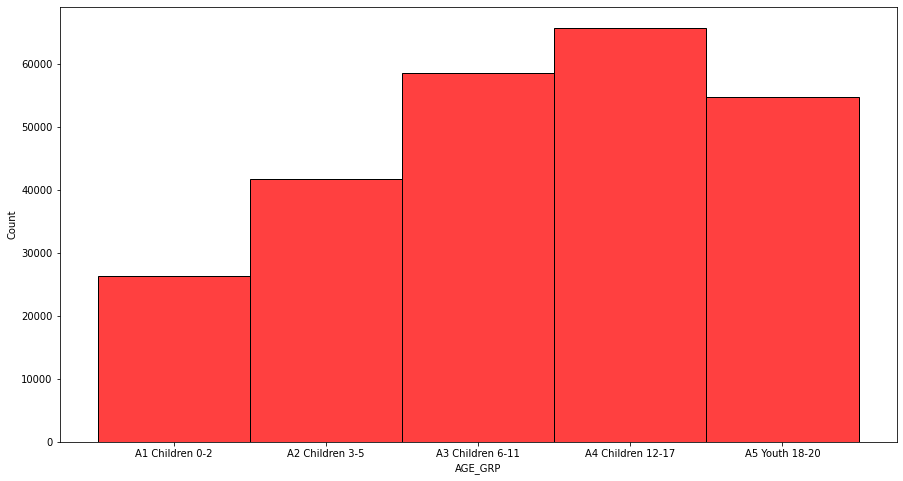

In [ ]:
plt.figure(figsize=(15,8))

sns.histplot(data=util, x="AGE_GRP", color="red")#, kde=True)
#sns.histplot(data=util, x="MHS_TYPE", color="blue")#, kde=True)

plt.show()

# Patients ages 12 to 17 require the bulk of care, as compared to other age groups in the dataset.

In [ ]:
pd.crosstab(util.AGE_GRP, util.MHS_TYPE)
# There are a lot more patients being treated under "MHS" instead of "SMHS"

# We can split the dataset, one set per MHS_TYPE, or combine the two, but balance the data so that
# it is not biased towards MHS, which contains the majority of the records.

MHS_TYPE,MHS,SMHS
AGE_GRP,,
A1 Children 0-2,21581,4818
A2 Children 3-5,31713,9964
A3 Children 6-11,43269,15274
A4 Children 12-17,47205,18522
A5 Youth 18-20,36946,17848


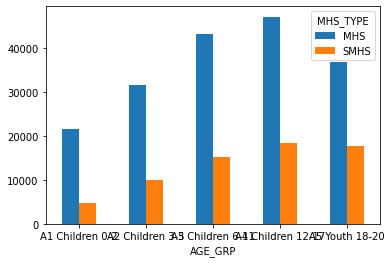

In [ ]:
age_mhstype_crosstb = pd.crosstab(util.AGE_GRP, util.MHS_TYPE)
age_mhstype_crosstb.plot.bar(rot=0)
# Visual representation of MHS_TYPE = "MHS" having the majority of patients.
# The trends between MHS_TYPE amongst the AGE_GRP appear similar, except for the
# last two AGE_GRP, where SMHS is very similar between groups 12-17 and 18-20. 

In [ ]:
age_time_group = pd.crosstab(util.AGE_GRP, util.FISCAL_YEAR)
age_time_group
# All groups show an increase; however, there is a decrease in the last year of the dataset, 2020,
# perhaps due to the pandemic.

FISCAL_YEAR,2017,2018,2019,2020
AGE_GRP,,,,
A1 Children 0-2,6193,6509,6953,6744
A2 Children 3-5,9976,10173,11120,10408
A3 Children 6-11,14059,14277,15516,14691
A4 Children 12-17,15380,16144,17491,16712
A5 Youth 18-20,12819,13586,14379,14010


<Figure size 936x432 with 0 Axes>

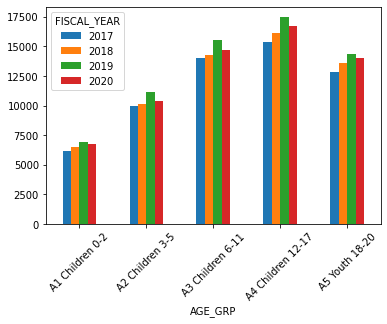

In [ ]:
plt.figure(figsize=(13,6))
age_time_group.plot.bar(rot=45)

In [ ]:
demo.head()

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,RACE_GRP,TOTAL_CT,TOTAL_CT_ANNOT,MHS1_CT,MHS1_CT_ANNOT,MHS5_CT,MHS5_CT_ANNOT,MHS_TYPE
0,Alameda,01,2017,R1 Alaskan Native or American Indian,392.0,NaN,26.0,NaN,NaN,1.0,MHS
1,Alameda,01,2017,R2 Asian or Pacific Islander,31643.0,NaN,1366.0,NaN,256.0,NaN,MHS
2,Alameda,01,2017,R3 Black,31057.0,NaN,2299.0,NaN,332.0,NaN,MHS
3,Alameda,01,2017,R4 Hispanic,73605.0,NaN,4964.0,NaN,835.0,NaN,MHS
4,Alameda,01,2017,R5 White,13401.0,NaN,1267.0,NaN,326.0,NaN,MHS


In [ ]:
demo_group = demo.groupby(['FISCAL_YEAR','RACE_GRP'])['TOTAL_CT'].sum()
demo_group

FISCAL_YEAR  RACE_GRP                            
2017         R1 Alaskan Native or American Indian      168432.0
             R2 Asian or Pacific Islander             3492246.0
             R3 Black                                 3452816.0
             R4 Hispanic                             29310256.0
             R5 White                                 7257112.0
             R6 Other                                 2502710.0
             R7 Unknown                               4293155.0
2018         R1 Alaskan Native or American Indian      161500.0
             R2 Asian or Pacific Islander             3241876.0
             R3 Black                                 3342461.0
             R4 Hispanic                             28594676.0
             R5 White                                 6876618.0
             R6 Other                                 2646802.0
             R7 Unknown                               4117084.0
2019         R1 Alaskan Native or American Indian     

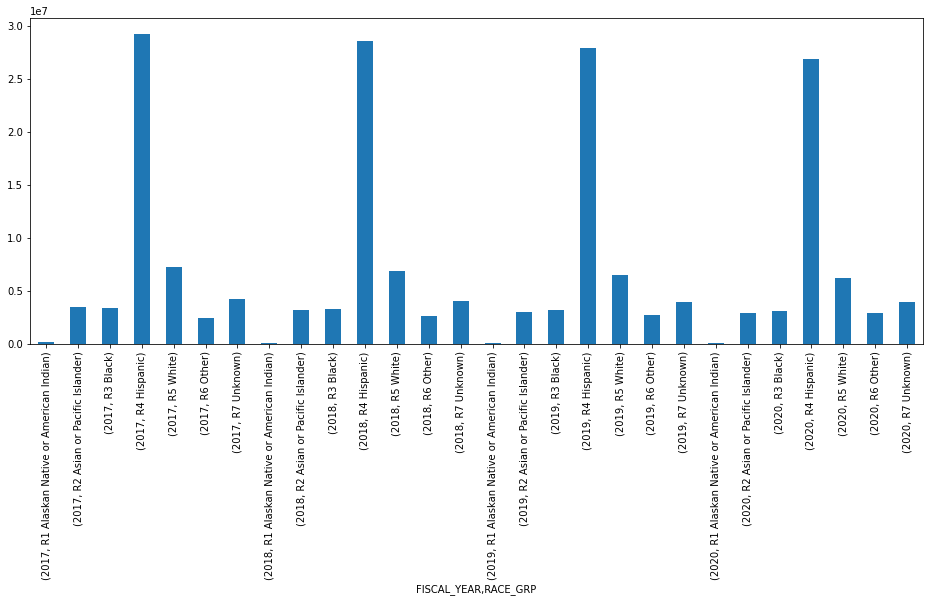

In [ ]:
demo_group.plot.bar(rot=90,figsize=(16,6))


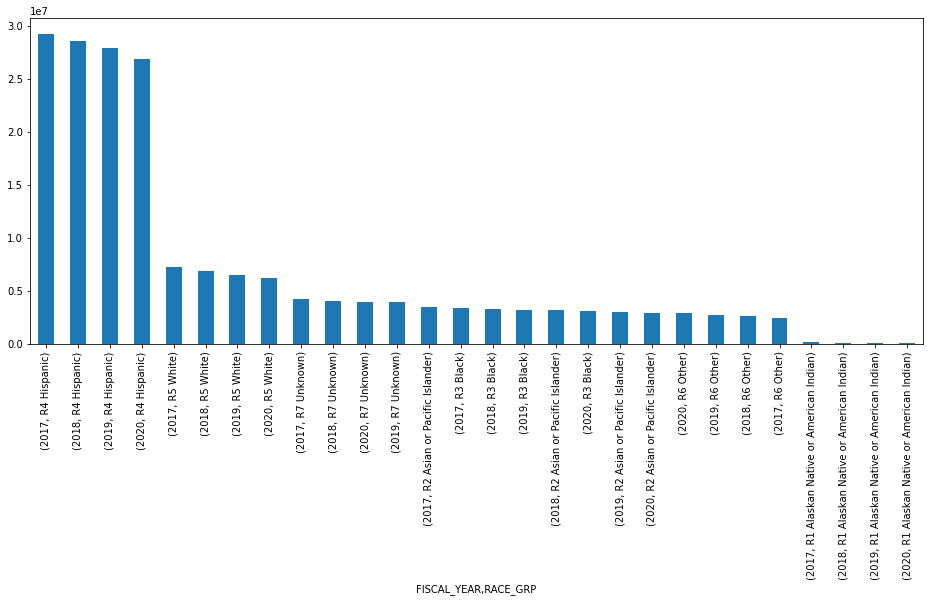

In [ ]:
dg_sorted = demo_group.sort_values(ascending=False)
dg_sorted
dg_sorted.plot.bar(rot=90,figsize=(16,6))


In [ ]:
age.head(30)

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,AGE_GRP,TOTAL_CT,TOTAL_CT_ANNOT,MHS1_CT,MHS1_CT_ANNOT,MHS5_CT,MHS5_CT_ANNOT,MHS_TYPE
0,Alameda,01,2017,A1 Children 0-2,26932.0,NaN,2026.0,NaN,44.0,NaN,MHS
1,Alameda,01,2017,A2 Children 3-5,26641.0,NaN,1120.0,NaN,255.0,NaN,MHS
2,Alameda,01,2017,A3 Children 6-11,54276.0,NaN,3442.0,NaN,790.0,NaN,MHS
3,Alameda,01,2017,A4 Children 12-17,50334.0,NaN,4119.0,NaN,840.0,NaN,MHS
4,Alameda,01,2017,A5 Youth 18-20,22436.0,NaN,1417.0,NaN,249.0,NaN,MHS


In [ ]:
df_age = age.groupby(['AGE_GRP','MHS_TYPE'],as_index=False)['TOTAL_CT'].sum()
df_age


,AGE_GRP,MHS_TYPE,TOTAL_CT
0,A1 Children 0-2,MHS,13995636.0
1,A1 Children 0-2,SMHS,13993664.0
2,A2 Children 3-5,MHS,14152638.0
3,A2 Children 3-5,SMHS,14150494.0
4,A3 Children 6-11,MHS,28883636.0
5,A3 Children 6-11,SMHS,28877784.0
6,A4 Children 12-17,MHS,27804764.0
7,A4 Children 12-17,SMHS,27774138.0
8,A5 Youth 18-20,MHS,12043406.0
9,A5 Youth 18-20,SMHS,11969395.0


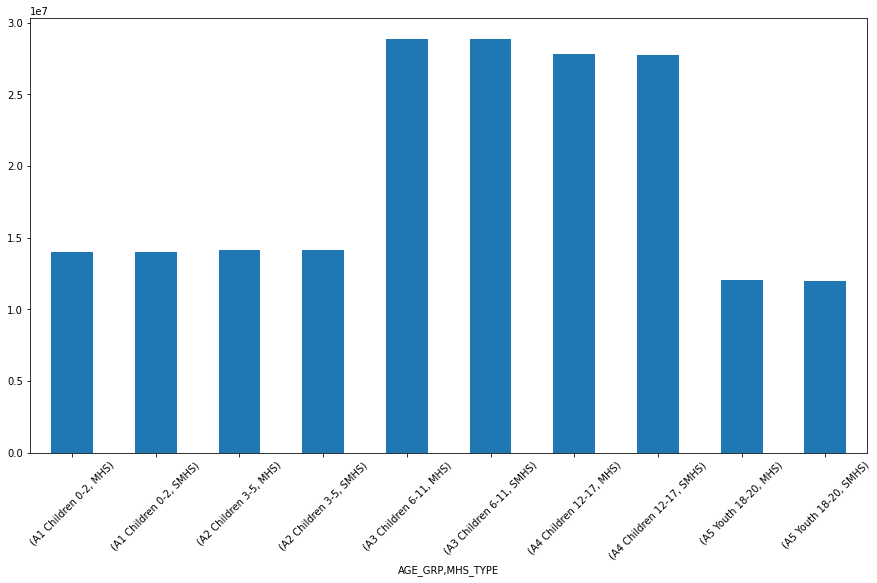

In [ ]:
df_age.plot.bar(rot=45,figsize=(15,8))

In [ ]:
df_age_diff = df_age.groupby(['AGE_GRP'])['TOTAL_CT'].diff().dropna()
#df_age['COUNT_DIFF'] = df_age_diff
df_age_diff = df_age_diff.abs()

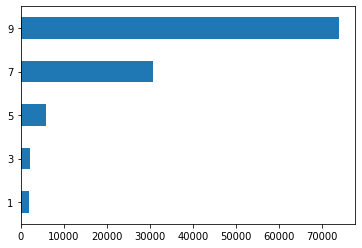

In [ ]:
df_age_diff.plot.barh()

Similarities between sets...
- FISCAL_YEAR
- MHS_TYPE
